<a href="https://colab.research.google.com/github/hariharannatesh/Dimension-Estimation-from-Depth-Map-of-Monocular-Image/blob/master/autoencoder_dg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from keras_preprocessing.image import ImageDataGenerator
import pandas as pd
import cv2
import numpy as np
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras import Input
from google.colab.patches import cv2_imshow
from tensorflow.keras import models
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow.keras.models import Model

In [ ]:
# First read the train and test CSV files as DataFrames
traindf=pd.read_csv('/content/gdrive/My Drive/Autoencoder_Dataset/train_info_autoencoder.csv')
testdf=pd.read_csv('/content/gdrive/My Drive/Autoencoder_Dataset/test_info_autoencoder.csv')

In [ ]:
def fixed_generator(generator):
    for batch in generator:
        yield (batch, batch)

In [ ]:
datagen=ImageDataGenerator(rescale=1./255,validation_split=0.25)
train_generator=datagen.flow_from_dataframe(
dataframe=traindf,
directory="/content/gdrive/My Drive/Autoencoder_Dataset/Depth/Depth_autoenco/",
x_col="Filename",
color_mode="grayscale",
#y_col="label",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode=None,
target_size=(424,512))
valid_generator=datagen.flow_from_dataframe(
dataframe=traindf,
directory="/content/gdrive/My Drive/Autoencoder_Dataset/Depth/Depth_autoenco/",
x_col="Filename",
color_mode="grayscale",
#y_col="label",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode=None,
target_size=(424,512))

print(type(next(valid_generator)))
print(next(valid_generator).shape)

Found 1248 validated image filenames.
Found 415 validated image filenames.
<class 'numpy.ndarray'>
(32, 424, 512, 1)


In [ ]:
test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
dataframe=testdf,
directory="/content/gdrive/My Drive/Autoencoder_Dataset/Depth/Depth_autoenco/",
x_col="Filename",
#y_col=None,
color_mode="grayscale",
batch_size=32,
seed=42,
shuffle=False,
class_mode=None,
target_size=(424,512))

Found 416 validated image filenames.


In [ ]:
input_img=Input(shape=(424,512,1))
nn=Conv2D(16,(7,7),activation='relu',padding='same')(input_img)
nn=MaxPool2D(pool_size=(4,4),strides=(4,4))(nn)
nn=Conv2D(32,(5,5),activation='relu',padding='same')(nn)
encoded=MaxPool2D(pool_size=(2,4),strides=(2,4),name="bottleneck")(nn)

dnn=Conv2D(32,(5,5),activation='relu',padding='same')(encoded)
dnn=UpSampling2D((2,4))(dnn)
dnn=Conv2D(16,(7,7),activation='relu',padding='same')(dnn)
dnn=UpSampling2D((4,4))(dnn)
decoded=Conv2D(1,(3,3),activation='sigmoid',padding='same')(dnn)




In [ ]:
model=Model(input_img,decoded)
model.summary()
model.compile(optimizer='adam',loss='mean_squared_error')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 424, 512, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 424, 512, 16)      800       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 106, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 106, 128, 32)      12832     
_________________________________________________________________
bottleneck (MaxPooling2D)    (None, 53, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 53, 32, 32)        25632     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 106, 128, 32)      0     

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
history=model.fit_generator(generator=fixed_generator(train_generator),
                    epochs=10,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=fixed_generator(valid_generator),
                    validation_steps=STEP_SIZE_VALID)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
39/39 [==============================] - 707s 18s/step - loss: 0.0435 - val_loss: 0.0176
Epoch 2/10
39/39 [==============================] - 630s 16s/step - loss: 0.0099 - val_loss: 0.0064
Epoch 3/10
39/39 [==============================] - 629s 16s/step - loss: 0.0049 - val_loss: 0.0040
Epoch 4/10
39/39 [==============================] - 628s 16s/step - loss: 0.0039 - val_loss: 0.0034
Epoch 5/10
39/39 [==============================] - 631s 16s/step - loss: 0.0036 - val_loss: 0.0034
Epoch 6/10
39/39 [==============================] - 631s 16s/step - loss: 0.0034 - val_loss: 0.0033
Epoch 7/10
39/39 [==============================] - 631s 16s/step - loss: 0.0033 - val_loss: 0.0032
Epoch 8/10
39/39 [==============================] - 630s 16s/step - loss: 0.0032 - val_loss: 0.0030
Epoch 9/10
39/39 [==============================] - 631s 16s/step - loss: 0.0030 - val_loss: 0.0028
Epoch 10/10
39/39 [=====

In [ ]:
test_generator.reset()
pred=model.predict_generator(fixed_generator(test_generator),
steps=STEP_SIZE_TEST,
verbose=1)

13/13 [==============================] - 47s 4s/step


(416, 424, 512, 1)
(424, 512)


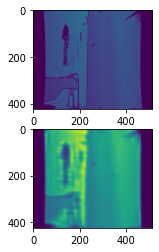

In [ ]:
from google.colab.patches import cv2_imshow
print(pred.shape)
fig,axs=plt.subplots(2)
img=cv2.imread(testdf.iloc[0,1],0)
img1=cv2.resize(img,(512,424))
print(img1.shape)
axs[0].imshow(img1)
axs[1].imshow(pred[0].reshape(424,512))

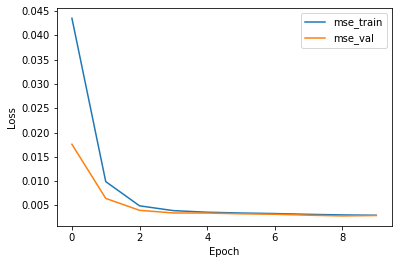

In [ ]:
plt.plot(history.history['loss'],label='mse_train')
plt.plot(history.history['val_loss'],label='mse_val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim(0,15000)
plt.legend(loc='upper right')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
encoder=Model(input_img,model.get_layer(name="bottleneck").output)
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 424, 512, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 424, 512, 16)      800       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 106, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 106, 128, 32)      12832     
_________________________________________________________________
bottleneck (MaxPooling2D)    (None, 53, 32, 32)        0         
Total params: 13,632
Trainable params: 13,632
Non-trainable params: 0
_________________________________________________________________


In [ ]:
encoder.save('/content/gdrive/My Drive/save_model/autoencoder_encoder_to_dimest_dg.h5')